## **Diarization**

In [5]:
from pyannote.audio import Pipeline
import torch
pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-community-1').to(torch.device('cuda'))

diarization = pipeline('cocktail_party_sample.wav')

for turn, speaker in diarization.speaker_diarization:
    print(f"{speaker} speaks between t={turn.start:.4f}s and t={turn.end:.4f}s")

/home/saimeur/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannote/audio/utils/reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
/home/saimeur/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


SPEAKER_00 speaks between t=6.7303s and t=6.7472s
SPEAKER_01 speaks between t=6.7472s and t=7.0341s
SPEAKER_00 speaks between t=7.0341s and t=7.1860s
SPEAKER_00 speaks between t=7.5910s and t=7.6078s
SPEAKER_01 speaks between t=7.6078s and t=8.3166s
SPEAKER_00 speaks between t=8.3166s and t=9.9197s
SPEAKER_01 speaks between t=9.9197s and t=10.9828s
SPEAKER_00 speaks between t=10.4597s and t=14.7460s
SPEAKER_01 speaks between t=14.3072s and t=17.8847s
SPEAKER_00 speaks between t=18.0197s and t=21.5128s
SPEAKER_01 speaks between t=18.1547s and t=18.4416s
SPEAKER_01 speaks between t=21.7660s and t=28.4991s
SPEAKER_00 speaks between t=27.8578s and t=29.9672s


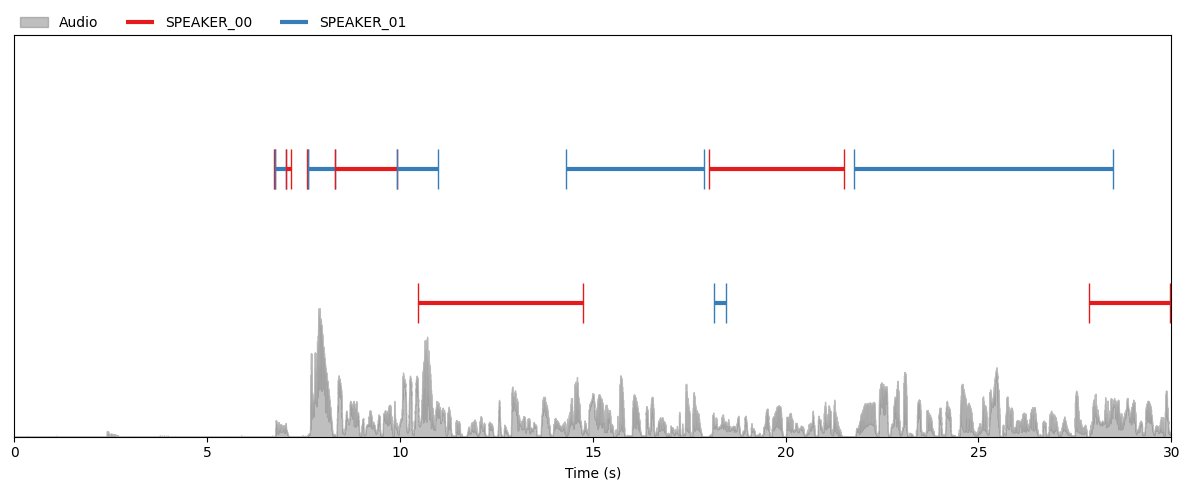

In [6]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pyannote.core import Segment, notebook

audio_path = 'cocktail_party_sample.wav'

annotation = diarization.speaker_diarization
y, sr = librosa.load(audio_path, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
notebook.crop = Segment(0, duration)

fig, ax = plt.subplots(figsize=(12, 5))

librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.5, color="gray", label="Audio")
notebook.plot_annotation(annotation, ax=ax, time=True, legend=True)

ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

Found 4!
Overlap detected from 10.5s to 11.0s
Overlap detected from 14.3s to 14.7s
Overlap detected from 18.2s to 18.4s
Overlap detected from 27.9s to 28.5s


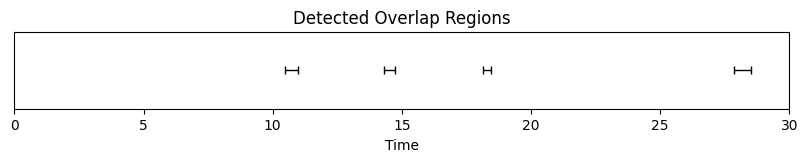

In [7]:
overlaps = annotation.get_overlap() # pyannote.core.annotation
print(f"Found {len(overlaps)}!")
for segment in overlaps:
    print(f"Overlap detected from {segment.start:.1f}s to {segment.end:.1f}s")

plt.figure(figsize=(10, 1))
notebook.plot_timeline(overlaps, time=True)
plt.title("Detected Overlap Regions")
plt.show()

## **Target Speaker Extraction**

In [11]:
# Install libraries if not already present
# !pip install speechbrain torchaudio sounddevice numpy scipy

import torch
import torchaudio
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write
from speechbrain.inference.separation import SepformerSeparation
from speechbrain.inference.speaker import EncoderClassifier
from IPython.display import Audio, display

print("Libraries installed and imported!")

Libraries installed and imported!


In [12]:
def record_audio(filename, duration=5, fs=16000):
    print(f"🎙️ Recording '{filename}' for {duration} seconds...")
    print("   (Speak now!)")
    
    # Record
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()  # Wait until recording is finished
    
    # Save as WAV
    # Squeeze to remove extra dimension if mono
    recording = recording.squeeze()
    
    # Normalize to -1 to 1 just in case
    if np.max(np.abs(recording)) > 0:
        recording = recording / np.max(np.abs(recording))
        
    write(filename, fs, (recording * 32767).astype(np.int16))
    
    print(f"✅ Saved to {filename}")
    return filename

In [ ]:
# Record your reference voice (The "Enrollment")
ref_file = record_audio("Iliass.wav", duration=5)

# Listen back to verify it's clean
print("\nYour Reference Audio:")
display(Audio(ref_file))

🎙️ Recording 'reference.wav' for 5 seconds...
   (Speak now!)
✅ Saved to reference.wav

Your Reference Audio:


In [ ]:
# Record the difficult audio (The "Mixture")
mix_file = record_audio("mixture.wav", duration=6)

# Listen back
print("\nThe Mixture Audio:")
display(Audio(mix_file))

In [ ]:
class TargetSpeakerExtractor:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"⚡ Loading models on {self.device}...")
        
        # 1. Separator (Splits audio into 2 sources)
        # Using SepFormer - State of the Art separation
        self.separator = SepformerSeparation.from_hparams(
            source="speechbrain/sepformer-wsj0-2mix",
            savedir="pretrained_models/sepformer-wsj0-2mix",
            run_opts={"device": self.device}
        )
        
        # 2. Recognizer (Identifies WHO the speaker is)
        # Using ECAPA-TDNN - State of the Art recognition
        self.recognizer = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-ecapa-voxceleb",
            savedir="pretrained_models/spkrec-ecapa-voxceleb",
            run_opts={"device": self.device}
        )
        print("✅ Models Ready.")

    def extract(self, mix_path, ref_path):
        print("🔍 Processing...")
        
        # --- A. ENROLL TARGET ---
        # Load your reference audio
        ref_wav, _ = torchaudio.load(ref_path)
        ref_wav = ref_wav.to(self.device)
        
        # Create a "fingerprint" (embedding) of your voice
        target_embedding = self.recognizer.encode_batch(ref_wav)
        
        # --- B. SEPARATE MIXTURE ---
        # Load mixture
        mix_wav, _ = torchaudio.load(mix_path)
        mix_wav = mix_wav.to(self.device)
        
        # Run separation (returns tensor [batch, time, 2])
        est_sources = self.separator.separate_batch(mix_wav)
        
        # --- C. FIND THE MATCH ---
        # source 1
        s1 = est_sources[:, :, 0]
        emb1 = self.recognizer.encode_batch(s1)
        score1 = torch.nn.functional.cosine_similarity(emb1, target_embedding, dim=-1)
        
        # source 2
        s2 = est_sources[:, :, 1]
        emb2 = self.recognizer.encode_batch(s2)
        score2 = torch.nn.functional.cosine_similarity(emb2, target_embedding, dim=-1)
        
        print(f"   Score Source 1: {score1.item():.2f}")
        print(f"   Score Source 2: {score2.item():.2f}")

        # Return the winner
        if score1 > score2:
            print("👉 Picked Source 1")
            return s1.cpu().squeeze().detach().numpy()
        else:
            print("👉 Picked Source 2")
            return s2.cpu().squeeze().detach().numpy()

# Initialize the engine (Downloads models on first run)
engine = TargetSpeakerExtractor()

In [ ]:
# Run the extraction
clean_audio = engine.extract("mixture.wav", "reference.wav")

# Display the result
print("\n✨ FINAL RESULT (Your Voice Only):")
display(Audio(clean_audio, rate=8000)) # Note: SepFormer output is usually 8k or 16k

## **BSS**

In [3]:
import sounddevice as sd
import soundfile as sf
import numpy as np
import torch
import torchaudio
from speechbrain.inference.separation import SepformerSeparation
from IPython.display import Audio, display

print("Libraries loaded!")


/home/saimeur/miniconda3/envs/voice_hack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/saimeur/miniconda3/envs/voice_hack/lib/python3.10/site-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()


Libraries loaded!


In [ ]:
# Cell 3: Record audio
duration = 15  # seconds
sample_rate = 16000  # Hz (16kHz for better quality)

print(f"Recording for {duration} seconds...")
print("Speak now! (mix multiple speakers if possible)")

recording = sd.rec(int(duration * sample_rate), 
                   samplerate=sample_rate, 
                   channels=1, 
                   dtype='float32')
sd.wait()

print("Recording finished!")

sf.write('mixture.wav', recording, sample_rate)
print("Saved as mixture.wav")

# Play back
display(Audio(recording.flatten(), rate=sample_rate))

Libraries loaded!
Recording for 15 seconds...
Speak now! (mix multiple speakers if possible)
Recording finished!
Saved as mixture.wav


In [8]:
print("Loading ConvTasNet 16kHz model...")
model = SepformerSeparation.from_hparams(
    source="speechbrain/sepformer-whamr16k",  # Real model that exists
    savedir="pretrained_models/sepformer-16k"
)

# Proper way to move SpeechBrain models to CUDA
if torch.cuda.is_available():
    model.device = torch.device('cuda')
    model.mods = model.mods.to('cuda')
    print("Model moved to CUDA!")
else:
    print("Using CPU")
    
print("Model loaded!")

# Cell 5: Separate speakers
print("Separating speakers...")
est_sources = model.separate_file(path='mixture_3_people.wav')

n_sources = est_sources.shape[-1]
print(f"Separated into {n_sources} sources")

Loading ConvTasNet 16kHz model...
Model moved to CUDA!
Model loaded!
Separating speakers...
Separated into 2 sources


In [9]:
for i in range(n_sources):
    source = est_sources[:, :, i].cpu().numpy()
    filename = f'speaker_{i+1}.wav'
    
    # Save
    sf.write(filename, source.T, sample_rate)
    print(f"Saved {filename}")
    
    # Play
    print(f"Speaker {i+1}:")
    display(Audio(source.flatten(), rate=sample_rate))

# Cell 7: (Optional) Compare original vs separated
print("Original mixture:")
display(Audio('mixture.wav'))

print("\nSeparated speakers:")
for i in range(n_sources):
    print(f"Speaker {i+1}:")
    display(Audio(f'speaker_{i+1}.wav'))

Saved speaker_1.wav
Speaker 1:


Saved speaker_2.wav
Speaker 2:


Original mixture:



Separated speakers:
Speaker 1:


Speaker 2:


## FastMNMFF

In [25]:
from fastmnmf import FastMNMF1, FastMNMF2
from scipy.signal import resample


def read_audio(file, dtype=None, fs_target=None, target_rms=0.1, max_duration_sec=None):
	signal, fs = sf.read(file)

	if dtype is not None:
		signal = signal.astype(dtype)

	# Normalizing
	signal -= np.mean(signal)

	if target_rms is not None:
		signal *= (target_rms / (np.std(signal) + 1e-8))

	if fs_target is not None and fs != fs_target:
		# Resample
		print(f"File {file} has samlpling rate of {fs} != {fs_target}")
		duration = len(signal) / fs
		num_samples_target = int(duration * fs_target)
		signal = resample(signal, num_samples_target).astype(dtype)
	
	if max_duration_sec is not None:
		num_samples_target = int(fs * max_duration_sec)
		if len(signal) > num_samples_target:
			random_start = np.random.randint(0, len(signal) - num_samples_target)
			signal = signal[random_start : random_start + num_samples_target]

	return signal

In [26]:
from fastmnmf import FastMNMF1, FastMNMF2

n_channel = 6
fs = 16000
audio_path = '/home/saimeur/workspace/projet_perso/voice_ai/mixture_3_people.wav'

noised_mixture = read_audio(file=audio_path, dtype='float16')
noised_mixture = np.array([noised_mixture])
print(f'Shape : {noised_mixture.shape}')

Shape : (1, 240000)


In [35]:
n_src = 3
n_fft = 510
hop_size = n_fft // 4 + 1
T = noised_mixture.shape[-1]
window = torch.hann_window(n_fft)

n_bases = 64
n_iter = 100
init_SCM = 'rc'
seed = 1

ref_mic_idx = 0
src = 1

In [36]:
noised_mixture_torch = torch.from_numpy(noised_mixture)	#n_mics, n_sample
# Normalize
norm_factor = noised_mixture_torch.abs().max()
norm_factor=1
noised_mixture_torch = noised_mixture_torch / norm_factor

X_torch = torch.stft(input=noised_mixture_torch,
                     n_fft=n_fft,
                     hop_length=hop_size,
                     window=window,
                     center=True,
                     return_complex=True
                     )   # n_mics, F, T
X_FTM = X_torch.permute(1,2,0)    # F, T, n_mics
print(X_FTM.shape)

# X_FTM = spec_fwd(X_FTM)
# Attention a decommenter ligne 625 de utils.py


torch.Size([256, 1876, 1])


In [37]:
model1 = FastMNMF2(X_FTM, n_src=n_src, n_bases=n_bases, n_iter=n_iter, init_SCM=init_SCM, seed=seed, device=torch.device('cuda'))
model1.fit()

In [38]:
from utils import get_separation
separated_src_freq, audio = get_separation(model=model1,
                                            n_fft=n_fft,
                                            hop_size=hop_size,
                                            length=T,
                                            norm_factor=norm_factor
                                            )

for i in range(n_src):
    display(Audio(audio[i].cpu().numpy(), rate=fs))

In [21]:
x = audio[0].squeeze().cpu().numpy()   # (240000,)
sample_rate = 16000                  # adapte si besoin

sd.play(x, samplerate=sample_rate)
sd.wait()
